<a href="https://colab.research.google.com/github/ludo1967/gallery3-contrib/blob/master/stable_diffusion_notebookui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion Notebook UI
Main workflow reference: https://medium.com/@natsunoyuki/using-civitai-models-with-diffusers-package-45e0c475a67e

Notebook reference: https://github.com/woctezuma/stable-diffusion-colab

In [1]:
%pip install --upgrade diffusers transformers mediapy compel accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.2 MB/s eta 0:00:00


In [2]:
# restart to use newly installed packages
restart = False # @param {type:"boolean"}
# @markdown > This is usually necessary for releasing RAM and VRAM.
if restart:
    import os
    os._exit(0)  # Restart the notebook

In [3]:
# @markdown ### **Fetch model file**
import os


mode = "huggingface" # @param ['http', 'gdrive', 'git', 'huggingface', 'local']
location = "stablediffusionapi/anything-v5" # @param {type:"string"}
model_filename = location.split('/')[-1]
match mode:
  case "http":
    !test -f $model_filename || wget $location
  case "gdrive":
    from google.colab import drive

    try:
       drive_path = "/content/drive"
       drive.mount(drive_path,force_remount=False)
    except:
       print("...error mounting drive or with drive path variables")
  case "git":
    !git clone --recursive --depth=1 $location
  case 'huggingface':
    model_dir = location
  case _:
    # default to local mode
    pass

if model_filename.endswith(".safetensors"):
  !test -f convert_original_stable_diffusion_to_diffusers.py || wget https://raw.githubusercontent.com/huggingface/diffusers/v$(pip show diffusers | grep Version | awk '{print $2}')/scripts/convert_original_stable_diffusion_to_diffusers.py
  model_dir = model_filename.split('.')[0]
  if mode == "http":
    location = model_filename
  !python convert_original_stable_diffusion_to_diffusers.py \
      --checkpoint_path $location \
      --dump_path $model_dir/ \
      --from_safetensors
elif mode != "http" and os.path.isdir(location):
  # use model directory directly
  model_dir = location

In [4]:
import mediapy as media
import random
import os
import sys
import gc

import torch
from diffusers import DiffusionPipeline
import transformers

# @markdown # Pipeline Settings

clip_skip = 1 # @param {type:"slider", min:1, max:12, step:1}
# @markdown > Clip skip = 1 uses the all text encoder layers.
# @markdown >
# @markdown > Clip skip = 2 skips the last text encoder layer.
force_cpu_processing = False # @param {type:"boolean"}
# @markdown > force using CPU device for interference
force_fp32_processing = False # @param {type:"boolean"}
# @markdown > force float32 processing format. Usually needed when image results are black.
use_accelerate = False # @param {type:"boolean"}
# @markdown > Use accelerate to fully utilize all GPUs.

torch.set_num_threads(os.cpu_count())
if use_accelerate:
    # Avoids initializing CUDA before processing
    device = torch.device("cpu")
    torch_dtype = torch.float16
elif not force_cpu_processing and torch.cuda.is_available():
    device = torch.device("cuda")
    torch_dtype = torch.float16
else:
    device = torch.device("cpu")
    torch_dtype = torch.float32

if force_fp32_processing:
  torch_dtype = torch.float32

# clean pipeline if exists
if "pipe" in locals():
  del pipe
  gc.collect()
  torch.cuda.empty_cache()

pipeline_kwargs = dict()
if clip_skip > 2:
  pipeline_kwargs['text_encoder'] = transformers.CLIPTextModel.from_pretrained(
      "runwayml/stable-diffusion-v1-5",
      subfolder = "text_encoder",
      num_hidden_layers = 12 - (clip_skip - 1),
      torch_dtype = torch_dtype
  )

if not use_accelerate:
    # Use late pipeline initializations for accelerate
    pipe = DiffusionPipeline.from_pretrained(
        model_dir,
        safety_checker = None,
        torch_dtype = torch_dtype,
        **pipeline_kwargs,
      ).to(device)

    if device.type != 'cpu':
        pipe.enable_model_cpu_offload()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/clip/feature_extraction_clip.py:30: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [5]:
# @markdown # Prepare utils functions
# Prompt embeddings to overcome CLIP 77 token limit.
# https://github.com/huggingface/diffusers/issues/2136
# https://huggingface.co/docs/diffusers/using-diffusers/weighted_prompts
from compel import Compel, ReturnedEmbeddingsType
from diffusers import StableDiffusionXLPipeline, AutoPipelineForImage2Image
from accelerate import Accelerator


def get_prompt_embeddings(
    pipeline,
    prompt,
    negative_prompt,
    device = torch.device("cpu")
):
    if isinstance(pipeline, StableDiffusionXLPipeline):
        compel = Compel(
          tokenizer=[pipeline.tokenizer, pipeline.tokenizer_2] ,
          text_encoder=[pipeline.text_encoder, pipeline.text_encoder_2],
          truncate_long_prompts=False,
          returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
          requires_pooled=[False, True],
          device=device
        )
        prompt_embeds, pooled_prompt_embeds = compel(prompt)
        negative_prompt_embeds, negative_pooled_prompt_embeds = compel(negative_prompt)
    else:
        compel = Compel(
          tokenizer=pipeline.tokenizer ,
          text_encoder=pipeline.text_encoder,
          truncate_long_prompts=False,
          returned_embeddings_type = ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NORMALIZED if clip_skip > 1 \
            else ReturnedEmbeddingsType.LAST_HIDDEN_STATES_NORMALIZED,
          requires_pooled=False,
          device=device
        )
        prompt_embeds, pooled_prompt_embeds = compel(prompt), None
        negative_prompt_embeds, negative_pooled_prompt_embeds = compel(negative_prompt), None

    prompt_embeds, negative_prompt_embeds = compel.pad_conditioning_tensors_to_same_length([prompt_embeds, negative_prompt_embeds])
    return prompt_embeds, pooled_prompt_embeds, negative_prompt_embeds, negative_pooled_prompt_embeds

def accelerated_generate(h, w, cfg_scale, num_inference_steps, batch_size, seeds, kwargs, result_list, use_prompt_embeddings):
    accelerator = Accelerator()
    device = accelerator.device

    pipe = DiffusionPipeline.from_pretrained(
        model_dir,
        safety_checker = None,
        torch_dtype = torch_dtype,
        **pipeline_kwargs,
      ).to(device)

    if use_prompt_embeddings:
        prompt_embeds, pooled_prompt_embeds, negative_prompt_embeds, negative_pooled_prompt_embeds = get_prompt_embeddings(
            pipe,
            kwargs.pop('prompt'),
            kwargs.pop('negative_prompt'),
            device = device
        )
        if isinstance(pipe, StableDiffusionXLPipeline):
            kwargs.update({
                'pooled_prompt_embeds': pooled_prompt_embeds,
                'negative_pooled_prompt_embeds': negative_pooled_prompt_embeds,
            })
        kwargs['prompt_embeds'] = prompt_embeds
        kwargs['negative_prompt_embeds'] = negative_prompt_embeds

    if 'image' in kwargs:
        pipe = AutoPipelineForImage2Image.from_pipe(pipe)

    with accelerator.split_between_processes(seeds) as task_seeds:
        images = pipe(
                height = h,
                width = w,
                guidance_scale = cfg_scale,
                num_inference_steps = num_inference_steps,
                num_images_per_prompt = len(task_seeds),
                generator = [torch.Generator(device).manual_seed(s) for s in task_seeds],
                **kwargs,
            ).images
        result_list.extend(zip(images, task_seeds))

  0%|          | 0/30 [00:00<?, ?it/s]

""

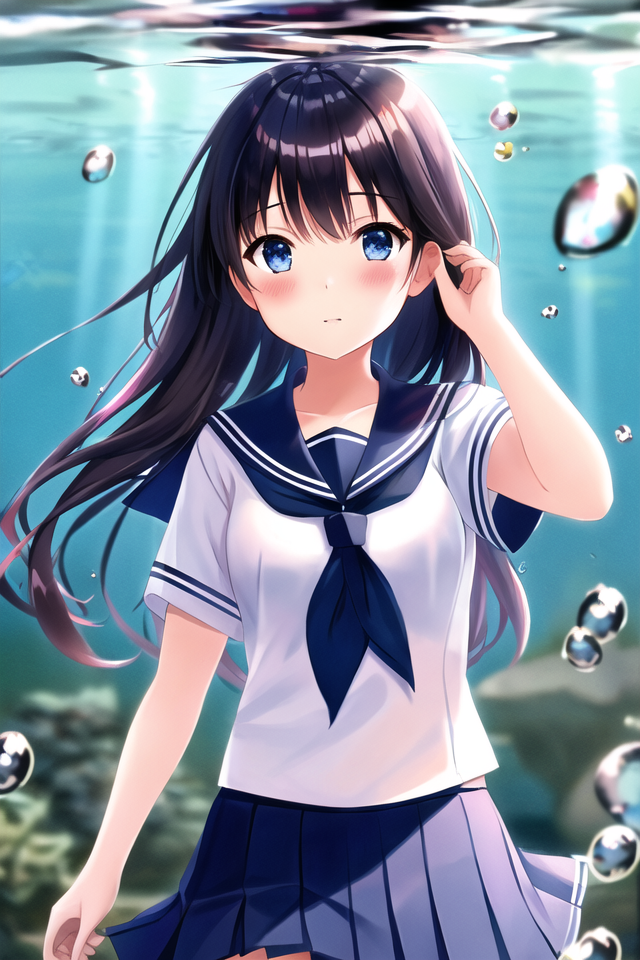

mkdir: created directory 'outputs'


In [6]:
from diffusers.utils import load_image
from time import time

# @markdown ### **Prompts**
# @markdown > Default parameters are from image https://civitai.com/images/963361
prompt = "bubble, rating:safe, air_bubble, underwater, 1girl, fish, long_hair, submerged, school_uniform, serafuku, solo, water, skirt, neckerchief, short_sleeves,(Impressionism:1.4)," # @param {type:"string"}
negative_prompt = "(mutated hands and fingers:1.5 ),(mutation, poorly drawn :1.2),(long body :1.3),(mutation, poorly drawn :1.2),liquid body,text font ui,long neck,uncoordinated body,fused ears,(ugly:1.4),one hand with more than 5 fingers,one hand with less than 5 fingers," # @param {type:"string"}
use_prompt_embeddings = True # @param {type:"boolean"}
# @markdown > Prompt embeddings: Overcome CLIP 77 tokens limit.

# @markdown ### **Image settings**
init_image_location = "" # @param {type:"string"}
# @markdown > init_image_location: The location of init image for img2img generations. If not empty, run img2img.
strength = 0.9 # @param {type:"slider", min:0, max:1, step:0.05}
# @markdown > strength: a higher strength value gives the model more “creativity” to generate an image that’s different from the initial image; a strength value of 1.0 means the initial image is more or less ignored;
# @markdown > a lower strength value means the generated image is more similar to the initial image
w = 640 # @param {type:"slider", min:64, max:2048, step:8}
h = 960 # @param {type:"slider", min:64, max:2048, step:8}
batch_count = 1 # @param {type:"integer"}
batch_size = 1 # @param {type:"integer"}

# @markdown ### **Generation settings**
cfg_scale = 9 # @param {type:"slider", min:1, max:27, step:0.5}
num_inference_steps = 30 # @param {type:"slider", min:1, max:150, step:1}

init_seed = 1678803042 # @param {type: "integer"}
#  @markdown > seed: set -1 for random seed

# Arguments preparation
prompt = ','.join(set(prompt.split(',')))
negative_prompt = ','.join(set(negative_prompt.split(',')))
results = []
seeds = [
    random.randint(0, sys.maxsize) if init_seed == -1
    else init_seed + i
    for i in range(batch_count * batch_size)
]
# round image size to be divisible by 8
w -= w % 8
h -= h % 8

kwargs = dict()
if use_prompt_embeddings and not use_accelerate:
    # for accelerate, embedding should be generated in forked processes with accelerate devices.
    prompt_embeds, pooled_prompt_embeds, negative_prompt_embeds, negative_pooled_prompt_embeds = get_prompt_embeddings(
      pipe,
      prompt,
      negative_prompt,
      device = device
    )
    if isinstance(pipe, StableDiffusionXLPipeline):
        kwargs = {
            'pooled_prompt_embeds': pooled_prompt_embeds,
            'negative_pooled_prompt_embeds': negative_pooled_prompt_embeds,
        }
    kwargs['prompt_embeds'] = prompt_embeds
    kwargs['negative_prompt_embeds'] = negative_prompt_embeds
else:
    kwargs['prompt'] = prompt
    kwargs['negative_prompt'] = negative_prompt

if init_image_location:
    init_image = load_image(init_image_location)
    kwargs['strength'] = strength
    print("Init image:")
    media.show_image(init_image)

for i in range(batch_count):
    batched_seeds = seeds[i * batch_size: (i + 1) * batch_size]
    if init_image_location:
        kwargs['image'] = [init_image] * batch_size

    if use_accelerate:
        from accelerate import notebook_launcher
        from multiprocessing import Manager

        with Manager() as manager:
            result_list = manager.list()
            notebook_launcher(
                accelerated_generate,
                (h, w, cfg_scale, num_inference_steps, batch_size, batched_seeds, kwargs, result_list, use_prompt_embeddings,),
                num_processes=torch.cuda.device_count()
            )
            results.extend(result_list)
            # Todo: may produce out of order image list
            # Todo: use fp16 with accelerate
    else:
        orig_pipe = pipe
        if init_image_location:
            pipe = AutoPipelineForImage2Image.from_pipe(pipe)
        images = pipe(
            height = h,
            width = w,
            guidance_scale = cfg_scale,
            num_inference_steps = num_inference_steps,
            num_images_per_prompt = batch_size,
            generator = [torch.Generator(device).manual_seed(s) for s in batched_seeds],
            **kwargs,
        ).images
        pipe = orig_pipe
        results.extend(zip(images, batched_seeds))

media.show_images([r[0] for r in results])

!mkdir -pv outputs
for img, seed in results:
    filename = f"outputs/{seed}.png"
    img.save(filename)

In [7]:
# @markdown Save Images
!zip -rv -9 outputs.zip outputs/

  adding: outputs/	(in=0) (out=0) (stored 0%)
  adding: outputs/1678803042.png 	(in=872060) (out=872125) (deflated 0%)
total bytes=872060, compressed=872125 -> 0% savings
